# Fitting more complex models to photometry with Bagpipes

In the previos example we covered some of the basics, now let's look at fitting a more complex model and some extra features.

## Setting up

Once again we'll need to load up the observational data, we'll use the same object as last time.

In [1]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits
from glob import glob

def load_uvista(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue.
    hdulist = np.loadtxt("UltraVISTA_catalogue.cat",
                         usecols=(0,3,4,5,6,7,8,9,10,11,12,13,14,15,
                                  16,17,18,19,20,21,22,23,24,25,26))

    # Check the object is in the catalogue.
    if np.min(np.abs(hdulist[:,0] - int(ID))) != 0:
        sys.exit("Object not found in catalogue")

    tablerow = np.argmin(np.abs(hdulist[:,0] - int(ID)))

    # Extract the object we're interested in from the catalogue.
    phot_fluxes = hdulist[tablerow, 1:13]
    phot_fluxerrs = hdulist[tablerow, 13:25]

    phot = np.zeros(len(phot_fluxes)*2)
    phot.shape = (len(phot_fluxes), 2)
    
    # Convert to microjanskys
    phot[:,0] = phot_fluxes*10**29
    phot[:,1] = phot_fluxerrs*10**29

    # blow up the errors associated with any N/A points in the phot
    for i in range(len(phot)):
        if ((phot[i, 0] == 0. or phot[i, 1] <= 0) 
                or (phot[i, 1] > 0 and -phot[i, 0] >= 2*phot[i, 1])):
            phot[i,:] = [0., 9.9*10**99.]

    return phot


uvista_filt_list = ["uvista/CFHT_u.txt",
                    "uvista/CFHT_g.txt",
                    "uvista/CFHT_r.txt",
                    "uvista/CFHT_i+i2.txt",
                    "uvista/CFHT_z.txt",
                    "uvista/subaru_z",
                    "uvista/VISTA_Y.txt",
                    "uvista/VISTA_J.txt",
                    "uvista/VISTA_H.txt",
                    "uvista/VISTA_Ks.txt",
                    "uvista/IRAC1",
                    "uvista/IRAC2"]

galaxy = pipes.galaxy("96976", load_uvista, spectrum_exists=False, 
                      filt_list=uvista_filt_list)

fig = galaxy.plot()

<Figure size 1200x400 with 1 Axes>

## Making a more interesting model

Instead of a plain old tau model let's try fitting a double-power-law star-formation history. This is also a good time to think about the priors we're imposing on our fitting parameters. By default bagpipes will fit a uniform prior between the limits you set, but you can change that as follows:

In [2]:
dblplaw = {}                        
dblplaw["tau"] = (0., 15.)                # Vary the time of peak star-formation between
                                          # the Big Bang at 0 Gyr and 15 Gyr later. In 
                                          # practice the code automatically stops this
                                          # exceeding the age of the universe at the 
                                          # observed redshift.
            
dblplaw["alpha"] = (0.01, 1000.)          # Vary the falling power law slope from 0.01 to 1000.
dblplaw["beta"] = (0.01, 1000.)           # Vary the rising power law slope from 0.01 to 1000.
dblplaw["alpha_prior"] = "log_10"         # Impose a prior which is uniform in log_10 of the 
dblplaw["beta_prior"] = "log_10"          # parameter betweenthe limits which have been set 
                                          # above as in Carnall et al. (2017).
dblplaw["massformed"] = (1., 15.)
dblplaw["metallicity"] = (0., 2.5)

dust = {}                           
dust["type"] = "Calzetti"
dust["Av"] = (0., 2.)

fit_info = {}                            # The fit instructions dictionary
fit_info["redshift"] = (0., 10.)         # Vary observed redshift from 0 to 10

fit_info["redshift_prior"] = "Gaussian"  # From looking at the spectrum in Example 2 it's an
fit_info["redshift_prior_mu"] = 1.0      # open secret that this  object is at around z = 1.
fit_info["redshift_prior_sigma"] = 0.25  # let's encode that information with a broad gaussian
                                         # prior centred on redshift 1. Parameters of priors
                                         # are passed starting with "parameter_prior_".
fit_info["dblplaw"] = dblplaw 
fit_info["dust"] = dust

# Fitting the same object multiple times with different runs

Now we're ready to fit the object, but there's a problem, the posterior distribution for the previous example is still there. We can get around this by setting the run keyword argument of the fit object, which saves the output posterior to "pipes/posterior/run" instead "pipes/posterior" and the same for output plots.


Bagpipes: fitting object 96976 with PyMultiNest

  analysing data from pipes/posterior/dblplaw_sfh/96976-.txt

Bagpipes: fitting complete in 156.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                 11.644    148.425    564.668
dblplaw:beta                   0.031      0.249     15.073
dblplaw:massformed            10.800     10.888     10.945
dblplaw:metallicity            0.247      0.504      0.914
dblplaw:tau                    3.855      5.455      5.705
dust:Av                        0.121      0.309      0.549
redshift                       0.905      0.948      0.984




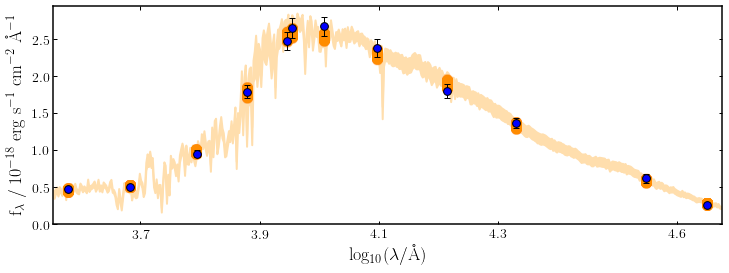

In [3]:
fit = pipes.fit(galaxy, fit_info, run="dblplaw_sfh")

fit.fit(sampler="pmn")

fig = fit.plot_fit(save=False)

To me this looks nicer than the previous example. Let's look at some other diagnostics:

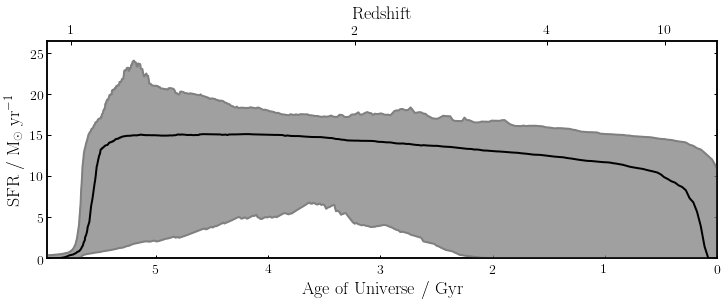

In [4]:
fig = fit.plot_sfh(save=False)

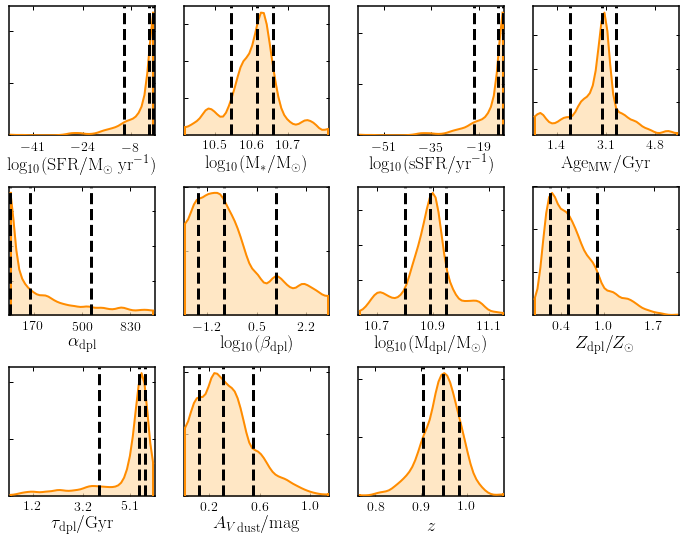

In [5]:
fit.plot_1d_posterior(save=False)

That's about it for fitting photometry, go on to the next example to learn about fitting spectroscopy.